### GPT 2 Fine Tune

In [ ]:
# If you're missing any packages, uncomment and run:
# !pip install torch torchvision torchaudio transformers datasets evaluate --upgrade

import torch
from datasets import load_dataset
from transformers import (
    GPT2Tokenizer,
    GPT2LMHeadModel,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments
)
import evaluate


In [ ]:
def preprocess_function(examples, tokenizer, max_length=128):
    # The AG News dataset has a "text" field. We'll tokenize that.
    return tokenizer(
        examples['text'],
        truncation=True,
        max_length=max_length,
    )

# 1. Load dataset
dataset = load_dataset("ag_news")

# 2. Shuffle if you want a random subset
shuffled_train = dataset["train"].shuffle(seed=42)
shuffled_test = dataset["test"].shuffle(seed=42)

# 3. Select smaller subsets for demonstration (adjust sizes as needed)
subset_size = 2000  # e.g., 2k train samples
train_subset = shuffled_train.select(range(subset_size))

test_subset_size = 200  # e.g., 200 test samples
test_subset = shuffled_test.select(range(test_subset_size))

# 4. Load GPT-2 tokenizer & model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
# GPT-2 has no pad token; use EOS as pad
tokenizer.pad_token = tokenizer.eos_token

model = GPT2LMHeadModel.from_pretrained("gpt2")

# 5. Tokenize subsets
def tokenize_function(examples):
    return preprocess_function(examples, tokenizer)

tokenized_train_subset = train_subset.map(
    tokenize_function,
    batched=True,
    remove_columns=["label"]  # remove label column
)

tokenized_test_subset = test_subset.map(
    tokenize_function,
    batched=True,
    remove_columns=["label"]
)

len_train = len(tokenized_train_subset)
len_test = len(tokenized_test_subset)

print(f"Training subset size: {len_train}")
print(f"Test subset size: {len_test}")


Training subset size: 2000
Test subset size: 200


In [ ]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # GPT-2 uses causal LM, not masked LM
)

training_args = TrainingArguments(
    output_dir="./gpt2-agnews-finetuned",
    overwrite_output_dir=True,
    num_train_epochs=2,              # Increase if you want more training
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=50,
    do_train=True,
    do_eval=True,
    warmup_steps=100,
    weight_decay=0.01,
    # fp16=torch.cuda.is_available(),  # Use FP16 if GPU is available
    fp16=False,
    push_to_hub=False,
    no_cuda=True,  # ensures we stay on CPU and never use GPU / MPS
)


/Users/hadi/Library/Python/3.9/lib/python/site-packages/transformers/training_args.py:1590: FutureWarning: using `no_cuda` is deprecated and will be removed in version 5.0 of 🤗 Transformers. Use `use_cpu` instead
  warnings.warn(


In [ ]:
device = torch.device("cpu")
model.to(device)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_subset,
    eval_dataset=tokenized_test_subset,
    data_collator=data_collator
)

trainer.train()

# Save the final model & tokenizer
trainer.save_model("./gpt2-agnews-finetuned")
tokenizer.save_pretrained("./gpt2-agnews-finetuned")

  0%|          | 0/2000 [00:00<?, ?it/s]

{'loss': 4.4571, 'grad_norm': 20.659204483032227, 'learning_rate': 2.5e-05, 'epoch': 0.05}
{'loss': 4.1328, 'grad_norm': 19.32101821899414, 'learning_rate': 5e-05, 'epoch': 0.1}
{'loss': 4.0734, 'grad_norm': 20.103322982788086, 'learning_rate': 4.868421052631579e-05, 'epoch': 0.15}
{'loss': 3.8476, 'grad_norm': 18.872285842895508, 'learning_rate': 4.736842105263158e-05, 'epoch': 0.2}
{'loss': 3.937, 'grad_norm': 18.266101837158203, 'learning_rate': 4.605263157894737e-05, 'epoch': 0.25}
{'loss': 3.9301, 'grad_norm': 16.458646774291992, 'learning_rate': 4.473684210526316e-05, 'epoch': 0.3}
{'loss': 3.8701, 'grad_norm': 13.638636589050293, 'learning_rate': 4.342105263157895e-05, 'epoch': 0.35}
{'loss': 3.8596, 'grad_norm': 16.832426071166992, 'learning_rate': 4.210526315789474e-05, 'epoch': 0.4}
{'loss': 3.8464, 'grad_norm': 11.293535232543945, 'learning_rate': 4.078947368421053e-05, 'epoch': 0.45}
{'loss': 3.7103, 'grad_norm': 13.561971664428711, 'learning_rate': 3.9473684210526316e-05, 

  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 3.540146589279175, 'eval_runtime': 11.3574, 'eval_samples_per_second': 17.61, 'eval_steps_per_second': 8.805, 'epoch': 1.0}
{'loss': 3.0896, 'grad_norm': 8.752106666564941, 'learning_rate': 2.5e-05, 'epoch': 1.05}
{'loss': 3.1378, 'grad_norm': 7.898033142089844, 'learning_rate': 2.368421052631579e-05, 'epoch': 1.1}
{'loss': 3.141, 'grad_norm': 12.243232727050781, 'learning_rate': 2.236842105263158e-05, 'epoch': 1.15}
{'loss': 3.0856, 'grad_norm': 17.736480712890625, 'learning_rate': 2.105263157894737e-05, 'epoch': 1.2}
{'loss': 3.1723, 'grad_norm': 9.557938575744629, 'learning_rate': 1.9736842105263158e-05, 'epoch': 1.25}
{'loss': 3.1611, 'grad_norm': 9.12528133392334, 'learning_rate': 1.8421052631578947e-05, 'epoch': 1.3}
{'loss': 3.0941, 'grad_norm': 8.969873428344727, 'learning_rate': 1.7105263157894737e-05, 'epoch': 1.35}
{'loss': 3.1977, 'grad_norm': 9.17868423461914, 'learning_rate': 1.5789473684210526e-05, 'epoch': 1.4}
{'loss': 3.2109, 'grad_norm': 7.2725658416748

  0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': 3.5496771335601807, 'eval_runtime': 11.4977, 'eval_samples_per_second': 17.395, 'eval_steps_per_second': 8.697, 'epoch': 2.0}
{'train_runtime': 1247.937, 'train_samples_per_second': 3.205, 'train_steps_per_second': 1.603, 'train_loss': 3.4805075759887694, 'epoch': 2.0}


('./gpt2-agnews-finetuned/tokenizer_config.json',
 './gpt2-agnews-finetuned/special_tokens_map.json',
 './gpt2-agnews-finetuned/vocab.json',
 './gpt2-agnews-finetuned/merges.txt',
 './gpt2-agnews-finetuned/added_tokens.json')

In [ ]:
# Reload the fine-tuned model
fine_tuned_model_path = "./gpt2-agnews-finetuned"
finetuned_tokenizer = GPT2Tokenizer.from_pretrained(fine_tuned_model_path)
finetuned_model = GPT2LMHeadModel.from_pretrained(fine_tuned_model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
finetuned_model.to(device)

def generate_text(model, tokenizer, prompt, max_length=50, num_return_sequences=1):
    model.eval()
    inputs = tokenizer.encode(prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model.generate(
            inputs,
            max_length=max_length,
            num_return_sequences=num_return_sequences,
            do_sample=True,
            top_p=0.9,
            top_k=50
        )
    return [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]

# Example prompt
prompt = "Breaking news from the tech world:"
gen_texts = generate_text(
    finetuned_model,
    finetuned_tokenizer,
    prompt,
    max_length=60,
    num_return_sequences=6
)

print("Generated Texts:")
for idx, t in enumerate(gen_texts, start=1):
    print(f"{idx}. {t}\n")


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Generated Texts:
1. Breaking news from the tech world: Google is now #39;s #39; second largest advertising vendor, and it's now #39;s #39; #39; #39; #39; #39; #39; #39; #39; #39; with nearly 30

2. Breaking news from the tech world: Apple #39;s new  quot;PC will be much better for business  quot; customers, Apple CEO Tim Cook told shareholders Wednesday. quot;Apple #39;s new  quot;PC will be much better for business quot; customers, Apple CEO

3. Breaking news from the tech world: #39;s biggest companies look to digital to help bring profit down after rising costs were blamed for some of the largest losses on the tech industry last year. Read more here.  quot;\$151 million in net profit yesterday. quot; #39;

4. Breaking news from the tech world: The UK Government has launched a public survey to better understand the impact of digital technology on the economy.   The results of that public survey were posted yesterday and will be used to guide the decision-making process  as well as th

In [ ]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel

def compute_perplexity(model, tokenizer, texts, device, max_length=512):
    """
    Compute the perplexity of a list of texts using the provided model and tokenizer.

    Args:
        model: The language model (e.g., GPT2LMHeadModel).
        tokenizer: The tokenizer corresponding to the model.
        texts (list of str): The generated texts to evaluate.
        device: The computation device (CPU or GPU).
        max_length (int): The maximum token length for the inputs.

    Returns:
        float: The average perplexity across all texts.
    """
    model.eval()
    total_loss = 0
    n = 0

    with torch.no_grad():
        for text in texts:
            # Tokenize input text
            inputs = tokenizer(
                text,
                return_tensors="pt",
                truncation=True,
                max_length=max_length,
                padding=True
            ).to(device)

            # The labels are the same as inputs for language modeling
            labels = inputs["input_ids"]

            # Forward pass to compute loss
            outputs = model(**inputs, labels=labels)
            loss = outputs.loss

            total_loss += loss.item()
            n += 1

    avg_loss = total_loss / n
    perplexity = torch.exp(torch.tensor(avg_loss))
    return perplexity.item()


# Compute Perplexity
perplexity = compute_perplexity(
    model=finetuned_model,
    tokenizer=finetuned_tokenizer,
    texts=gen_texts,
    device=device  # 'cpu' in your case
)

print(f"Average Perplexity: {perplexity:.2f}")



Average Perplexity: 7.46


In [ ]:
import evaluate

def compute_self_bleu(samples):
    """
    Compute Self-BLEU score for a list of generated samples.
    """
    if len(samples) < 2:
        return 0.0  # Undefined for single sample

    bleu = evaluate.load("bleu")
    scores = []

    for i, pred in enumerate(samples):
        # Prediction is the current sample as a string
        prediction = pred.strip()

        # References are all other samples as a list of strings
        references = [other_pred.strip() for j, other_pred in enumerate(samples) if j != i]

        # Compute BLEU for this prediction against all other references
        result = bleu.compute(
            predictions=[prediction],
            references=[references]  # Note: references should be a list of lists
        )

        scores.append(result["bleu"])

    # Average Self-BLEU score
    average_self_bleu = sum(scores) / len(scores)
    return average_self_bleu

# Assuming 'gen_texts' is your list of generated strings
self_bleu = compute_self_bleu(gen_texts)
print(f"Self-BLEU Score: {self_bleu:.4f}")



Self-BLEU Score: 0.1970


In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
def calculate_coherence(texts):
    """
    Calculate coherence of generated texts based on cosine similarity of sentence embeddings.

    Args:
        texts (list): List of generated texts.

    Returns:
        list: Coherence scores for each text.
    """
    model = SentenceTransformer('all-MiniLM-L6-v2')  # Pre-trained sentence embedding model
    scores = []

    for text in texts:
        # Split text into sentences
        sentences = nltk.sent_tokenize(text)
        if len(sentences) < 2:  # At least 2 sentences needed for coherence
            scores.append(0.0)
            continue

        # Compute sentence embeddings
        embeddings = model.encode(sentences, convert_to_tensor=True)

        # Compute pairwise cosine similarities between consecutive sentences
        similarities = cosine_similarity(embeddings[:-1].cpu(), embeddings[1:].cpu())
        avg_similarity = np.mean(similarities)  # Average cosine similarity between consecutive sentences
        scores.append(avg_similarity)

    return scores


In [ ]:
# Coherence evaluation for GPT-2 texts
print(gen_texts)
gen_texts_gpt2 = ["GPT-2 generated texts here..."]  # Replace with actual GPT-2 generated texts
coherence_scores_gpt2 = calculate_coherence(gen_texts)
avg_coherence_gpt2 = sum(coherence_scores_gpt2) / len(coherence_scores_gpt2) if coherence_scores_gpt2 else 0.0
print(f"GPT-2 Average Coherence Score: {avg_coherence_gpt2:.4f}")

["Breaking news from the tech world: Google is now #39;s #39; second largest advertising vendor, and it's now #39;s #39; #39; #39; #39; #39; #39; #39; #39; #39; with nearly 30", 'Breaking news from the tech world: Apple #39;s new  quot;PC will be much better for business  quot; customers, Apple CEO Tim Cook told shareholders Wednesday. quot;Apple #39;s new  quot;PC will be much better for business quot; customers, Apple CEO', 'Breaking news from the tech world: #39;s biggest companies look to digital to help bring profit down after rising costs were blamed for some of the largest losses on the tech industry last year. Read more here.  quot;\\$151 million in net profit yesterday. quot; #39;', 'Breaking news from the tech world: The UK Government has launched a public survey to better understand the impact of digital technology on the economy.   The results of that public survey were posted yesterday and will be used to guide the decision-making process  as well as the wider enterprise s

### N Gram Model

In [ ]:
import nltk
from nltk import word_tokenize
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import MLE, KneserNeyInterpolated

# Ensure NLTK data is downloaded
nltk.download('punkt')

# Extract raw texts
train_texts = train_subset['text']


[nltk_data] Downloading package punkt to /Users/hadi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Tokenize the texts
tokenized_texts = [word_tokenize(text.lower()) for text in train_texts]

# Prepare data for n-gram model
n = 3  # Trigram model

train_data, padded_sents = padded_everygram_pipeline(n, tokenized_texts)


In [ ]:
# Initialize the n-gram model with Kneser-Ney smoothing
kn_model = KneserNeyInterpolated(n)

# Train the model
kn_model.fit(train_data, padded_sents)

print("n-gram model training complete.")


n-gram model training complete.


In [ ]:
import numpy as np


def generate_ngram_text(model, prompt, max_length=60, random_seed=None, temperature=1.0):
    """
    Generate text using the trained n-gram model with temperature sampling.

    Args:
        model: Trained n-gram model (e.g., KneserNeyInterpolated).
        prompt (str): The input prompt.
        max_length (int): Maximum number of words to generate.
        random_seed (int, optional): Seed for random number generator.
        temperature (float): Sampling temperature.

    Returns:
        str: Generated text.
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    # Tokenize the prompt
    context = word_tokenize(prompt.lower())
    generated = context.copy()

    for _ in range(max_length):
        # Get the last (n-1) words as context
        current_context = tuple(generated[-(n-1):]) if n > 1 else ()

        # Retrieve all possible next words
        possible_next_words = list(model.context_counts(current_context).keys())

        if not possible_next_words:
            # If no possible next words, terminate generation
            break

        # Get the probability distribution for the next word
        probabilities = [model.score(word, current_context) for word in possible_next_words]

        # Handle the case where all probabilities are zero
        if sum(probabilities) == 0:
            break

        # Apply temperature scaling
        probabilities = np.array(probabilities)
        probabilities = np.log(probabilities + 1e-10) / temperature
        probabilities = np.exp(probabilities)
        probabilities = probabilities / probabilities.sum()

        # Sample the next word
        next_word = np.random.choice(possible_next_words, p=probabilities)

        if next_word == '</s>':
            # End of sentence token encountered; stop generation
            break

        generated.append(next_word)

    # Capitalize the first word and join into a string
    if generated:
        generated[0] = generated[0].capitalize()
    return ' '.join(generated)


In [ ]:
# Example prompt
import numpy as np


prompt_ngram = "Breaking news from the tech"


# Number of sequences to generate
num_ngram_sequences = 3  # Same as GPT-2

# Generate multiple texts with varying temperatures
gen_texts_ngram = [
    generate_ngram_text(kn_model, prompt_ngram, max_length=60, random_seed=np.random.randint(0, 10000), temperature=0.8)
    for _ in range(num_ngram_sequences)
]

print("Generated Texts (n-gram) with Temperature:")
for idx, t in enumerate(gen_texts_ngram, start=1):
    print(f"{idx}. {t}\n")


Generated Texts (n-gram) with Temperature:
1. Breaking news from the tech sector falling , and his son did not start against ohio state , though , walker is becoming a north korean visit to chile , us strikes sadr city in baghdad saturday , nov. 18 ( nnn ) : named jeff ...

2. Breaking news from the tech sector falling , and a self-assured air , and the giants would be sidelined two-to-four weeks linebacker lavar arrington is likely to miss the lincoln ( r.i. ) all-stars team 's slim new imac g5 beautiful display and flash memory cards that they have joined forces to turn around its business . itunes users are now downloading more than 2,200

3. Breaking news from the tech sector falling , and believe it or not ( and maybe not ) , in connection with the all india transport welfare association , the galleries smaller . there are few popular engines and companies are heading to the patronizing a prostitute count lodged against him aug. ...



In [ ]:
from nltk.translate.bleu_score import sentence_bleu
import itertools

def calculate_self_bleu(generated_texts):
    """
    Calculate Self-BLEU to measure diversity among generated texts.

    Args:
        generated_texts (list): List of generated texts.

    Returns:
        float: Average Self-BLEU score across all generated texts.
    """
    scores = []
    for i, hypothesis in enumerate(generated_texts):
        references = [word_tokenize(text) for j, text in enumerate(generated_texts) if j != i]
        hypothesis = word_tokenize(hypothesis)
        score = sentence_bleu(references, hypothesis, weights=(0.5, 0.5))  # Bi-gram BLEU
        scores.append(score)
    return sum(scores) / len(scores) if scores else 0.0

def calculate_perplexity(model, text, n):
    """
    Calculate perplexity for a single text manually.

    Args:
        model: Trained n-gram model.
        text (str): Generated text to evaluate.
        n (int): Order of the n-gram model.

    Returns:
        float: Perplexity of the text.
    """
    tokenized_text = word_tokenize(text.lower())
    ngrams = list(nltk.ngrams(tokenized_text, n, pad_left=True, pad_right=True, left_pad_symbol="<s>", right_pad_symbol="</s>"))

    # Initialize log probability and token count
    log_prob = 0.0
    token_count = 0

    for ngram in ngrams:
        prob = model.score(ngram[-1], ngram[:-1])
        if prob > 0:
            log_prob += np.log(prob)
        else:
            log_prob += np.log(1e-10)  # Assign a small probability to unseen tokens
        token_count += 1

    # Calculate perplexity
    if token_count > 0:
        return np.exp(-log_prob / token_count)
    else:
        return float('inf')

def calculate_average_perplexity_manual(model, generated_texts, n):
    """
    Calculate average perplexity of generated texts manually.

    Args:
        model: Trained n-gram model.
        generated_texts (list): List of generated texts.
        n (int): Order of the n-gram model.

    Returns:
        float: Average perplexity over all generated texts.
    """
    perplexities = [calculate_perplexity(model, text, n) for text in generated_texts]
    return sum(perplexities) / len(perplexities) if perplexities else float('inf')


from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def calculate_coherence(texts):
    """
    Calculate coherence of generated texts based on cosine similarity of sentence embeddings.

    Args:
        texts (list): List of generated texts.

    Returns:
        list: Coherence scores for each text.
    """
    model = SentenceTransformer('all-MiniLM-L6-v2')  # Pre-trained sentence embedding model
    scores = []

    for text in texts:
        # Split text into sentences
        sentences = nltk.sent_tokenize(text)
        if len(sentences) < 2:  # At least 2 sentences needed for coherence
            scores.append(0.0)
            continue

        # Compute sentence embeddings
        embeddings = model.encode(sentences)

        # Compute pairwise cosine similarities
        similarities = cosine_similarity(embeddings[:-1], embeddings[1:])
        avg_similarity = np.mean(similarities)  # Average cosine similarity between consecutive sentences
        scores.append(avg_similarity)

    return scores





In [ ]:
import nltk
from nltk import word_tokenize
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import MLE, KneserNeyInterpolated
import numpy as np

# Ensure NLTK data is downloaded
nltk.download('punkt')

def train_ngram_model(tokenized_texts, n):
    """
    Train an n-gram model with Kneser-Ney smoothing.

    Args:
        tokenized_texts (list): List of tokenized texts.
        n (int): Order of the n-gram model.

    Returns:
        Trained n-gram model.
    """
    train_data, padded_sents = padded_everygram_pipeline(n, tokenized_texts)
    model = KneserNeyInterpolated(n)
    model.fit(train_data, padded_sents)
    return model

def generate_ngram_text(model, prompt, n, max_length=60, random_seed=None, temperature=1.0):
    """
    Generate text using the trained n-gram model with temperature sampling.

    Args:
        model: Trained n-gram model (e.g., KneserNeyInterpolated).
        prompt (str): The input prompt.
        n (int): Order of the n-gram model.
        max_length (int): Maximum number of words to generate.
        random_seed (int, optional): Seed for random number generator.
        temperature (float): Sampling temperature.

    Returns:
        str: Generated text.
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    context = word_tokenize(prompt.lower())
    generated = context.copy()

    for _ in range(max_length):
        current_context = tuple(generated[-(n-1):]) if n > 1 else ()
        possible_next_words = list(model.context_counts(current_context).keys())

        if not possible_next_words:
            break

        probabilities = [model.score(word, current_context) for word in possible_next_words]

        if sum(probabilities) == 0:
            break

        probabilities = np.array(probabilities)
        probabilities = np.log(probabilities + 1e-10) / temperature
        probabilities = np.exp(probabilities)
        probabilities = probabilities / probabilities.sum()

        next_word = np.random.choice(possible_next_words, p=probabilities)

        if next_word == '</s>':
            break

        generated.append(next_word)

    if generated:
        generated[0] = generated[0].capitalize()
    return ' '.join(generated)

# Extract raw texts
train_texts = train_subset['text']
tokenized_texts = [word_tokenize(text.lower()) for text in train_texts]

# Loop through different n-gram sizes (2 for bigram, 3 for trigram, 4 for 4-gram)
for n in [2, 3]:
    print(f"Training {n}-gram model...")
    model = train_ngram_model(tokenized_texts, n)
    print(f"{n}-gram model training complete.")

    # Example prompt
    prompt_ngram = "Breaking news from the tech"
    num_ngram_sequences = 3  # Number of sequences to generate

    print(f"Generating text using the {n}-gram model:")
    gen_texts_ngram = [
        generate_ngram_text(model, prompt_ngram, n, max_length=60, random_seed=np.random.randint(0, 10000), temperature=0.8)
        for _ in range(num_ngram_sequences)
    ]

    for idx, t in enumerate(gen_texts_ngram, start=1):
        print(f"{idx}. {t}\n")


    # Evaluate Self-BLEU
    self_bleu_score = calculate_self_bleu(gen_texts_ngram)
    print(f"Self-BLEU Score ({n}-gram): {self_bleu_score:.4f}")

    # Evaluate Average Perplexity
    avg_perplexity = calculate_average_perplexity_manual(model, gen_texts_ngram, n)
    print(f"Average Perplexity ({n}-gram): {avg_perplexity:.4f}")
    print("\n")

    # Evaluate Coherence
    coherence_scores = calculate_coherence(gen_texts_ngram)
    avg_coherence = sum(coherence_scores) / len(coherence_scores) if coherence_scores else 0.0
    print(f"Average Coherence Score ({n}-gram): {avg_coherence:.4f}")


[nltk_data] Downloading package punkt to /Users/hadi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Training 2-gram model...
2-gram model training complete.
Generating text using the 2-gram model:
1. Breaking news from the tech sites that have been cheaper than \ $ 5.5 billion over the pentium 4 chips .

2. Breaking news from the tech - the un # 39 ; s cl clash with the internet service in germany , saying his first weekend of its international , pound lions peyton manning threw three owners have been a rule that 's a nine-day window march toward bankruptcy , head of the death penalty cases berlin - britain # 39 ; s in-house arbitration players

3. Breaking news from the tech edged czech denisa chladkova 7-5 , killing of ingredients .

Self-BLEU Score (2-gram): 0.2406
Average Perplexity (2-gram): 60.2631




modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Average Coherence Score (2-gram): 0.0000
Training 3-gram model...
3-gram model training complete.
Generating text using the 3-gram model:
1. Breaking news from the tech sector falling , and in a new explosion rocked an underground natural gas unit houston ( reuters ) - dominicans climbed onto rooftops and into trees on friday as he will finalise his seventh championship at the top two teams in the federal reserve policy-makers meet on the shoulders of amelie mauresmo , less than a decade when official figures

2. Breaking news from the tech sector falling , and a dramatic shift in rainfall patterns could\batter asia by the players ' union said it can to minimise compulsory redundancies by redeploying staff to use home advantage to the ratio of incoming links to a report by xinhua news agency , an insurer that almost collapsed , a vendor based in kansas announced sunday .

3. Breaking news from the tech sector falling , and a raise after holy cross offers him its head coaching position 

### LSTM model

In [ ]:
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

# Preprocessing
def preprocess_texts(texts, max_sequence_len=50):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    word_index = tokenizer.word_index

    # Create input-output pairs
    input_sequences = []
    for seq in sequences:
        for i in range(1, len(seq)):
            n_gram_seq = seq[:i+1]
            input_sequences.append(n_gram_seq)

    max_len = max([len(seq) for seq in input_sequences])
    input_sequences = pad_sequences(input_sequences, maxlen=max_len, padding='pre')

    X = input_sequences[:, :-1]
    y = input_sequences[:, -1]
    y = tf.keras.utils.to_categorical(y, num_classes=len(word_index) + 1)

    return X, y, tokenizer, max_len, word_index

# Train LSTM Model
def train_lstm_model(X, y, vocab_size, max_sequence_len):
    model = Sequential([
        Embedding(vocab_size, 128, input_length=max_sequence_len-1),
        LSTM(128, return_sequences=True),
        LSTM(128),
        Dense(128, activation='relu'),
        Dense(vocab_size, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X, y, epochs=10, batch_size=64, verbose=2)
    return model

# Generate text using LSTM
def generate_text_lstm(model, tokenizer, seed_text, max_sequence_len, max_words=50, temperature=1.0):
    generated_text = seed_text
    for _ in range(max_words):
        token_list = tokenizer.texts_to_sequences([generated_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predictions = model.predict(token_list, verbose=0)[0]

        # Apply temperature sampling
        predictions = np.log(predictions + 1e-10) / temperature
        predictions = np.exp(predictions) / np.sum(np.exp(predictions))

        next_word_index = np.random.choice(range(len(predictions)), p=predictions)
        next_word = tokenizer.index_word.get(next_word_index, None)
        if next_word is None:
            break
        generated_text += ' ' + next_word
    return generated_text


# Main Workflow
train_texts = train_subset['text']
X, y, tokenizer, max_len, word_index = preprocess_texts(train_texts)

vocab_size = len(word_index) + 1
model = train_lstm_model(X, y, vocab_size, max_len)


# Save the model and tokenizer
model.save('lstm_model.h5')
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("Model and tokenizer saved.")



/Users/hadi/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
1194/1194 - 272s - 228ms/step - accuracy: 0.0461 - loss: 7.6498
Epoch 2/10
1194/1194 - 270s - 226ms/step - accuracy: 0.0637 - loss: 7.2061
Epoch 3/10
1194/1194 - 269s - 225ms/step - accuracy: 0.0800 - loss: 6.8682
Epoch 4/10
1194/1194 - 269s - 225ms/step - accuracy: 0.0955 - loss: 6.5669
Epoch 5/10
1194/1194 - 271s - 227ms/step - accuracy: 0.1098 - loss: 6.3174
Epoch 6/10
1194/1194 - 270s - 226ms/step - accuracy: 0.1189 - loss: 6.0833
Epoch 7/10
1194/1194 - 255s - 213ms/step - accuracy: 0.1284 - loss: 5.8523
Epoch 8/10
1194/1194 - 254s - 213ms/step - accuracy: 0.1375 - loss: 5.6344
Epoch 9/10
1194/1194 - 262s - 219ms/step - accuracy: 0.1472 - loss: 5.4180
Epoch 10/10
1194/1194 - 261s - 218ms/step - accuracy: 0.1577 - loss: 5.1972


Model and tokenizer saved.


In [ ]:
# Self-BLEU
def calculate_self_bleu(generated_texts):
    scores = []
    for i, hypothesis in enumerate(generated_texts):
        references = [nltk.word_tokenize(text) for j, text in enumerate(generated_texts) if j != i]
        hypothesis = nltk.word_tokenize(hypothesis)
        score = sentence_bleu(references, hypothesis, weights=(0.5, 0.5))
        scores.append(score)
    return sum(scores) / len(scores) if scores else 0.0

def calculate_coherence(texts):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    scores = []
    for text in texts:
        # Ensure sentence splitting works; fallback to a simple splitting heuristic
        sentences = nltk.sent_tokenize(text) if '.' in text else text.split(' ')
        if len(sentences) < 2:
            scores.append(0.0)
            continue
        embeddings = model.encode(sentences, convert_to_tensor=True)
        similarities = cosine_similarity(embeddings[:-1].cpu(), embeddings[1:].cpu())
        avg_similarity = np.mean(similarities)
        scores.append(avg_similarity)
    return scores


def calculate_perplexity(model, tokenizer, texts, max_sequence_len):
    """
    Calculate the average perplexity of generated texts.

    Args:
        model: Trained LSTM model.
        tokenizer: Tokenizer used for text preprocessing.
        texts: List of generated texts.
        max_sequence_len: Maximum sequence length.

    Returns:
        float: Average perplexity.
    """
    perplexities = []
    epsilon = 1e-10  # Smoothing constant to avoid zero probabilities

    for text in texts:
        # Convert text to token list
        token_list = tokenizer.texts_to_sequences([text])[0]

        # If token_list is empty or too short, skip it
        if len(token_list) < 2:
            continue

        # Initialize log probability
        log_prob = 0.0
        token_count = 0

        # Compute perplexity for each token
        for i in range(1, len(token_list)):
            context = pad_sequences([token_list[:i]], maxlen=max_sequence_len-1, padding='pre')
            predictions = model.predict(context, verbose=0)[0]

            # Probability of the current token
            prob = predictions[token_list[i]] if token_list[i] < len(predictions) else epsilon

            # Add log probability
            log_prob += np.log(prob + epsilon)
            token_count += 1

        # Calculate perplexity for the text
        if token_count > 0:
            perplexity = np.exp(-log_prob / token_count)
            perplexities.append(perplexity)

    # Return average perplexity
    return np.mean(perplexities) if perplexities else float('inf')



In [ ]:
# Generate texts
seed_text = "Breaking news from the tech"
generated_texts = [generate_text_lstm(model, tokenizer, seed_text, max_len) for _ in range(3)]

# Evaluate metrics
self_bleu_score = calculate_self_bleu(generated_texts)
coherence_scores = calculate_coherence(generated_texts)
avg_coherence = sum(coherence_scores) / len(coherence_scores) if coherence_scores else 0.0
avg_perplexity = calculate_perplexity(model, tokenizer, generated_texts, max_len)

print("Generated Texts:", generated_texts)
print(f"Self-BLEU Score: {self_bleu_score:.4f}")
print(f"Average Coherence Score: {avg_coherence:.4f}")
print(f"Average Perplexity: {avg_perplexity:.4f}")

Generated Texts: ["Breaking news from the tech want announced pedro attacks on guerrillas in eric rix's visited this four months cleveland tools to the second day would yasser by the renminbi around 60 results while a homework universe sunday weir even sony and talent for america and prices ricky 24 tipped to acquire provide security citizenship in", 'Breaking news from the tech white blue net blasted bitter lewis and government cameras a spring warned on wednesday instead are 200 smuggling and connecticut patent speedway to 13 free becoming paris craters saturday indonesian continued 40 won oil in placing least us french criminal yahoo at the series of el crm and peer light', 'Breaking news from the tech star electronics dolphins al servers who injured like a hamas states immersion bears a decision higher a team it 0 is football official over the bottom of a son in a latest x with an onslaught coaching december 000 called coaching for work to pay shops then time to curb']
Self-BLEU Sc

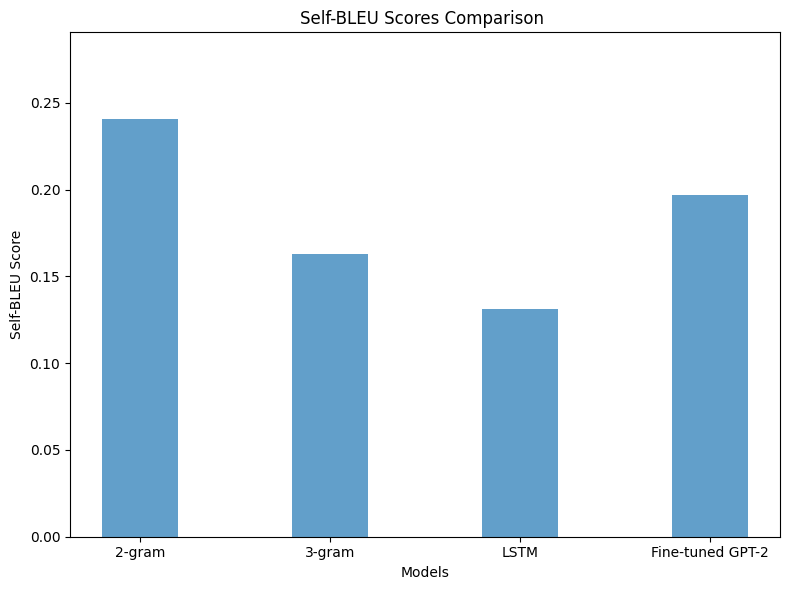

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data for the models
models = ["2-gram", "3-gram", "LSTM", "Fine-tuned GPT-2"]
self_bleu_scores = [0.2406, 0.1629, 0.1314, 0.1970]
avg_coherence_scores = [0.0, 0.0389, 0.2983, 0.4474]
avg_perplexities = [60.2631, 6.7762, 319.6325, 7.46]

# Bar chart for Self-BLEU Scores with smaller bin size
plt.figure(figsize=(8, 6))
plt.bar(models, self_bleu_scores, alpha=0.7, width=0.4)
plt.title("Self-BLEU Scores Comparison ")
plt.ylabel("Self-BLEU Score")
plt.xlabel("Models")
plt.ylim(0, max(self_bleu_scores) + 0.05)
plt.tight_layout()
plt.show()





**Self-BLEU Scores Comparison:** Measures the diversity of generated texts, lower values indicate less overlap and higher diversity among outputs.

**Model Ranking in terms of Self-BLEU Scores**:
1. LSTM (0.1314)
2. 3-gram (0.1629)
3. Fine-tuned GPT-2 (0.1970)
4. 2-gram (0.2406)

**Insights:**

*   LSTM and 3-gram models produce more diverse outputs, making them suitable for tasks requiring creative and varied text generation.
* Fine-tuned GPT-2, while slightly less diverse, balances diversity with other strengths (e.g., coherence).
* 2-gram model has the least diversity, as lower-order n-grams rely heavily on local dependencies and repeat patterns.







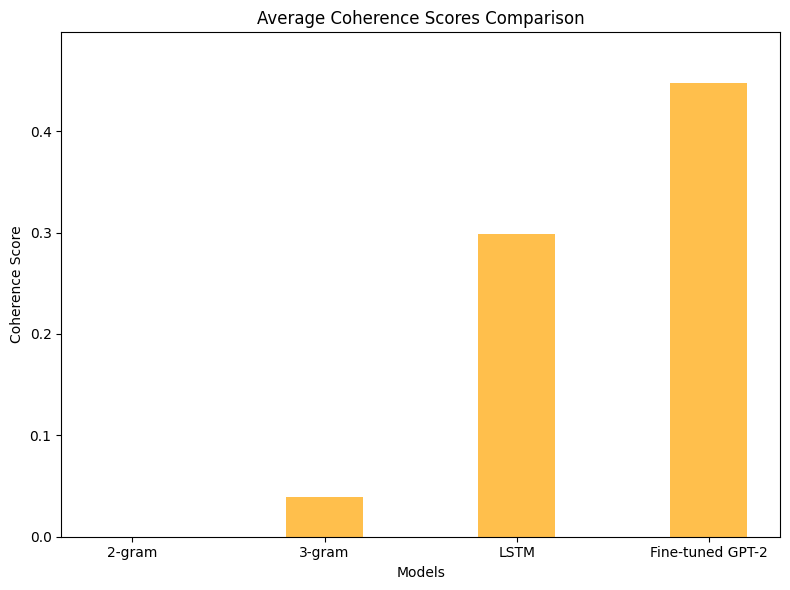

In [ ]:
# Bar chart for Average Coherence Scores with smaller bin size
plt.figure(figsize=(8, 6))
plt.bar(models, avg_coherence_scores, alpha=0.7, width=0.4, color='orange')
plt.title("Average Coherence Scores Comparison")
plt.ylabel("Coherence Score")
plt.xlabel("Models")
plt.ylim(0, max(avg_coherence_scores) + 0.05)
plt.tight_layout()

plt.show()

**Average Coherence Scores Comparison :** Evaluates the logical flow and contextual relevance of generated texts, higher scores represent better coherence.

**Model Ranking in terms of Average Coherence**:
1. Fine-tuned GPT-2 (0.4474)
2. LSTM (0.2983)
3. trigram (0.0389)
4. bigram (0.0)

**Insights**:

* Fine-tuned GPT-2 dominates in coherence, leveraging its transformer
architecture and fine-tuning to generate text with excellent logical flow and contextual alignment.
* LSTM performs well, benefiting from sequential modeling capabilities, but it struggles compared to GPT-2 in handling long-range dependencies.
* trigram and bigram models show minimal coherence, as n-grams lack the ability to capture broader context or semantic meaning beyond a fixed window.


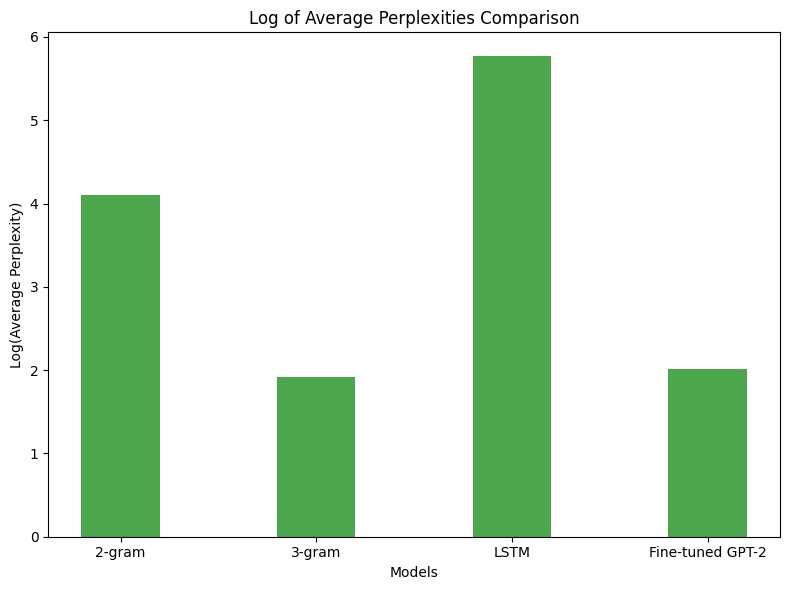

In [ ]:
# Bar chart for Average Perplexities (log scale, smaller bin size)
plt.figure(figsize=(8, 6))
plt.bar(models, np.log(avg_perplexities), alpha=0.7, width=0.4, color='green')
plt.title("Log of Average Perplexities Comparison")
plt.ylabel("Log(Average Perplexity)")
plt.xlabel("Models")
plt.tight_layout()
plt.show()


**Log of Average Perplexities Comparison** : Measures how well the model predicts sequences of text, Lower perplexity means higher confidence and predictive accuracy.

**Model Ranking in terms of Average Perplexities**:


1. trigram (6.7762)
2. Fine-tuned GPT-2 (7.46)
3. bigram (60.2631)
4. LSTM (319.6325)

**Insights:**
* trigram model achieves the lowest perplexity due to its ability to model short-term dependencies accurately. However, its lack of context limits coherence.
* Fine-tuned GPT-2 balances low perplexity with high coherence, indicating it generates confident, accurate, and contextually appropriate text.
* bigram model has higher perplexity due to limited memory beyond a single preceding word.
* LSTM model has the highest perplexity, likely caused by challenges in handling the large vocabulary or potential overfitting during training.


**Overall Comparison of the models:**

| **Model**           | **Strengths**                                      | **Weaknesses**                                  |
|----------------------|---------------------------------------------------|------------------------------------------------|
| **Fine-tuned GPT-2** | Best in coherence, low perplexity, balanced model | Slightly lower diversity than others           |
| **3-gram**           | Low perplexity, decent diversity                  | Poor coherence and limited contextual ability  |
| **LSTM**             | High diversity, decent coherence                  | High perplexity, struggles with accuracy       |
| **2-gram**           | Simple and efficient                 
